In [1]:
import numpy as np
import pickle
import csv
import torch
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten
from sklearn import svm, metrics
from sklearn.decomposition import PCA

In [2]:
sensor_data = []
times = []
with open('data/1_300_20.csv', 'r') as f:
    reader = csv.reader(f)
    # times = [row[0] for row in reader]
    for row in reader:
        if row[0] =='Timestamp':
            continue
        else:
            times.append(row[0])
            values = []
            for i in range(17):
                b1 = int(row[2*i+1])
                b2 = int(row[2*i+2])
                values.append(int.from_bytes([b1, b2], byteorder="little"))
            sensor_data.append(values)
sensor_data = np.array(sensor_data)
sequence = pickle.load(open('data/1_300_20_sequence.pkl', 'rb'))

(0.0, 5996.0)

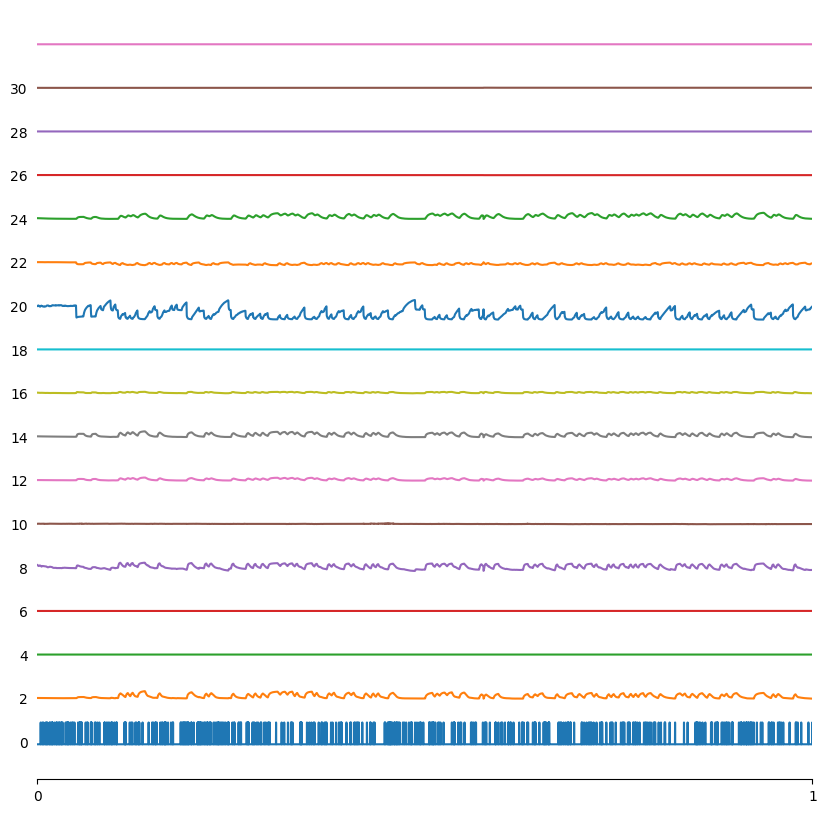

In [3]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i, row in enumerate(sensor_data.T):
    baseline = np.mean(row[:300])
    signal = (np.array(row) - baseline)/65536.
    if i==0:
        ax.plot(times, signal)
    else:
        ax.plot(times, signal*6 + 2*i )
ax.set_yticks(2*np.arange(16))
ax.set_xticks([times[0], times[-1]], labels=[0,1])
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.tick_params(left=False, labelleft=True)
ax.set_xlim([times[0], times[-1]])

# plt.savefig('figs/test.png', dpi=300)

In [4]:
responding_sens = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]

In [5]:
from datetime import datetime

# Convert to seconds
times_sec = []
for dt_str in times:
    dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')
    seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
    times_sec.append(seconds)
sequence_sec = []
for dt_str in sequence:
    dt = datetime.strptime(dt_str[0], '%a %b %d %H:%M:%S %Y')
    seconds = dt.hour * 3600 + dt.minute * 60 + dt.second
    sequence_sec.append(seconds)
times_sec = np.array(times_sec)
sequence_sec = np.array(sequence_sec)

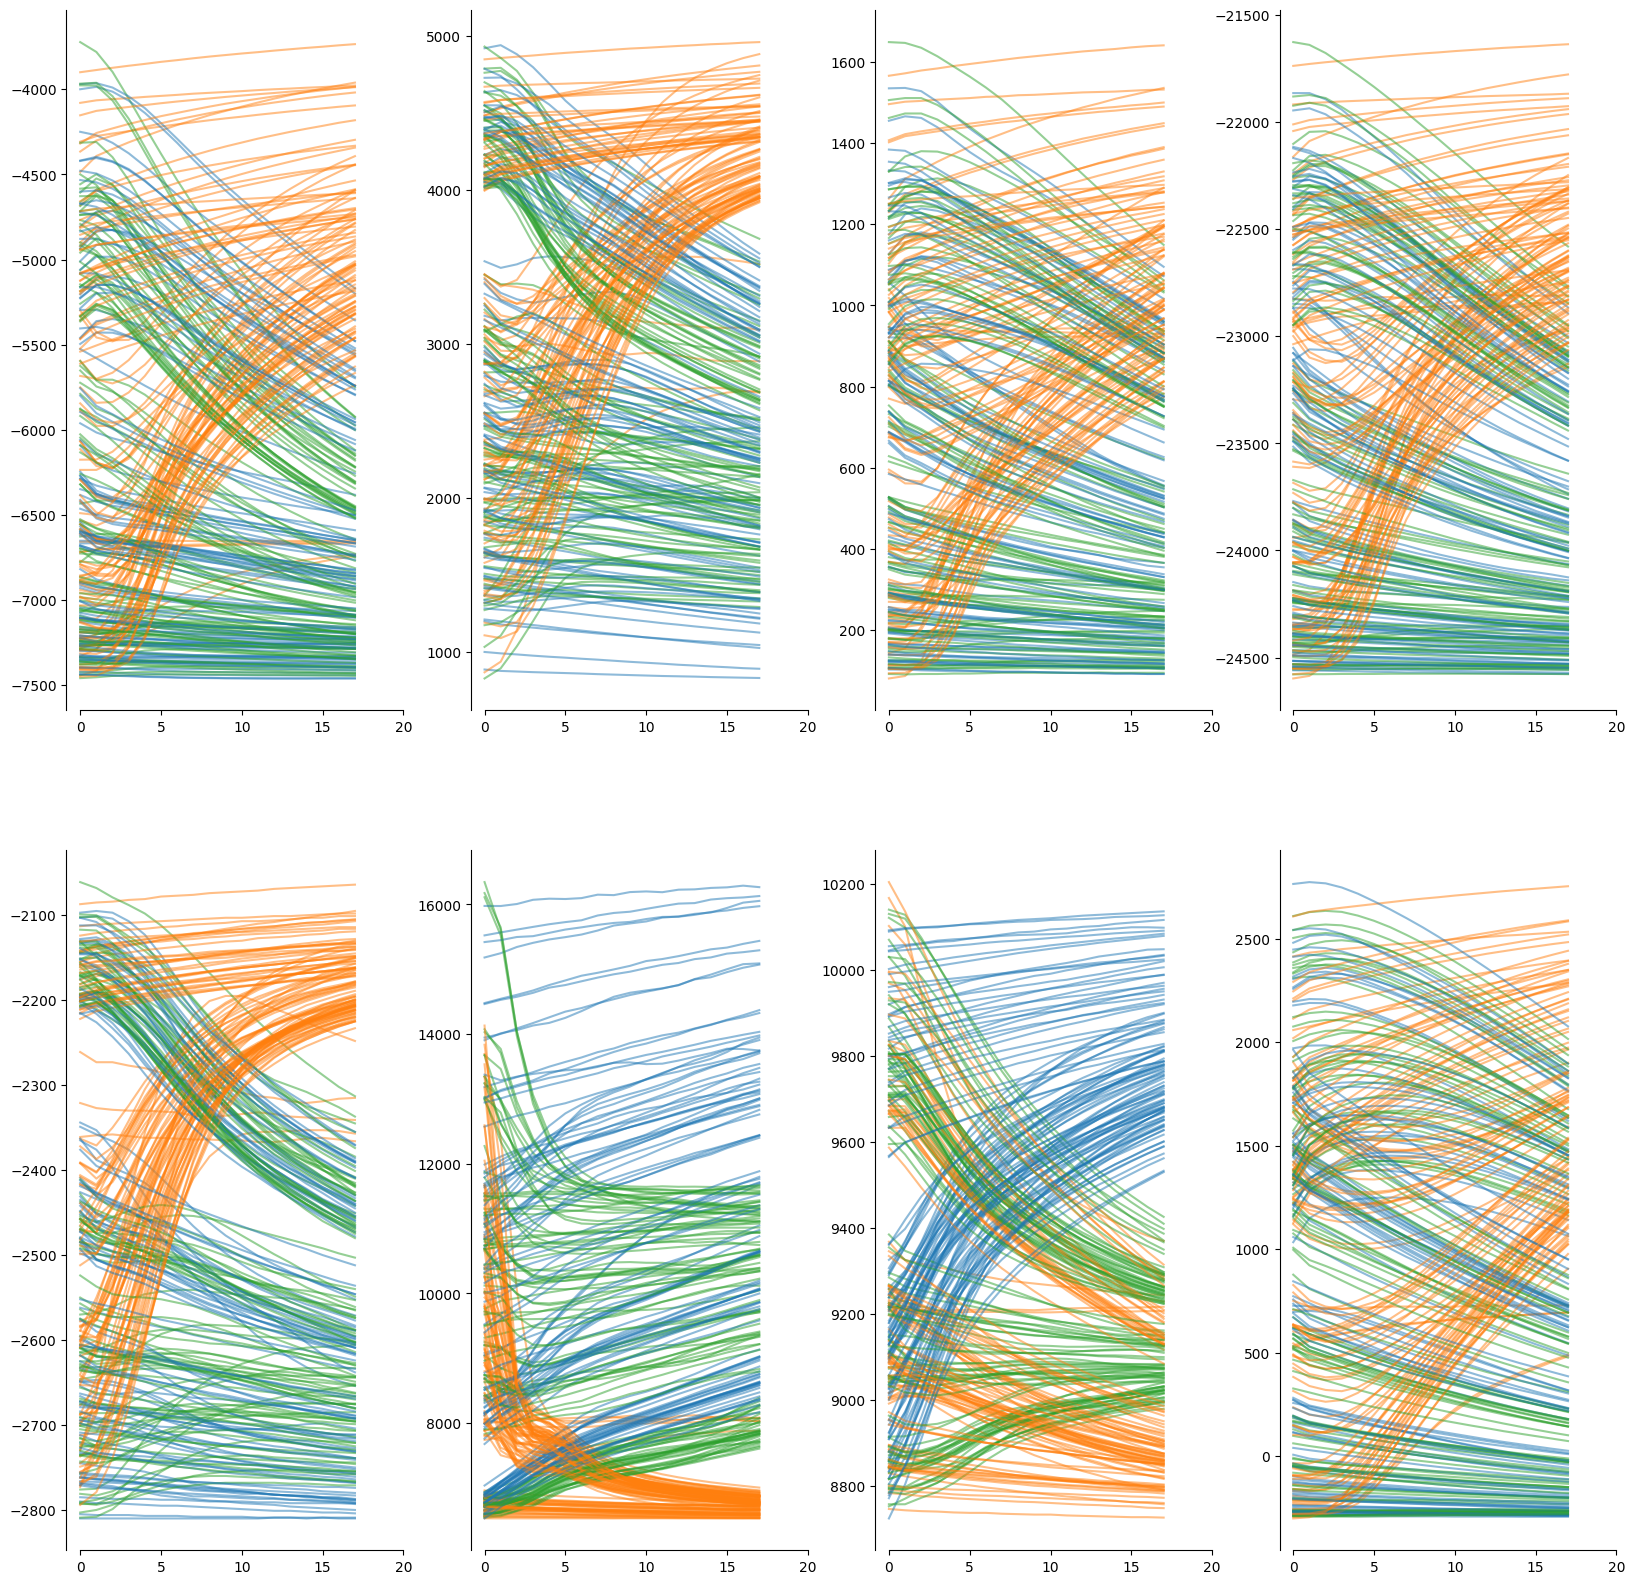

In [6]:
delay = 1.5
t_baseline = 300
n_train = 225

fig, ax = plt.subplots(2,4, figsize=(20,20))
cm = plt.get_cmap('tab10')

baseline = np.mean(sensor_data[:t_baseline], axis=0)
X_train = []
Y_train = []
I_train = []
X_test = []
Y_test = []
I_test = []
counts = np.zeros((3))

for i, t in enumerate(sequence_sec):
    try:
        flags = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1] + delay)
    except IndexError:
        flags = (times_sec > sequence_sec[i])
    sample = sensor_data[flags][:18]
    t_sample = times_sec[flags][:18]

    responding_sens = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
    sample = np.delete(sample, np.where(np.array(responding_sens)==0)[0], axis=1)

    x0 = sample[0, :]
    t0 = t_sample[0]
    int = np.zeros((sample.shape[1]))
    for k in range(1, sample.shape[0]):
        dif = np.abs(sample[k, :] - x0)/(t_sample[k] - t0)
        int += dif


    if counts[sequence[i][1]-1] < n_train//3:
        X_train.append(sample.flatten())
        Y_train.append(sequence[i][1]-1)
        I_train.append(int)
        counts[sequence[i][1]-1] += 1
    else:
        X_test.append(sample.flatten())
        Y_test.append(sequence[i][1]-1)
        I_test.append(int)



    # if i<225:
    #     X_train.append(sample.flatten())
    #     Y_train.append(sequence[i][1]-1)
    # else:
    #     X_test.append(sample.flatten())
    #     Y_test.append(sequence[i][1]-1)

    for j in range(sample.shape[1]):
        if sequence[i][1] == 1:
            ax[j//4, j%4].plot(sample[:, j] - baseline[j], alpha=0.5, c=cm(0))
        elif sequence[i][1] == 2:
            ax[j//4, j%4].plot(sample[:, j] - baseline[j], alpha=0.5, c=cm(1))
        elif sequence[i][1] == 3:
            ax[j//4, j%4].plot(sample[:, j] - baseline[j], alpha=0.5, c=cm(2))

for a in fig.axes:
    a.spines[['top', 'right']].set_visible(False)
    a.spines[['bottom']].set_bounds(0, 20)
    a.set_xticks(np.arange(0,25,5))

X_train = np.array(X_train)
Y_train = np.array(Y_train)
I_train = np.array(I_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
I_test = np.array(I_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



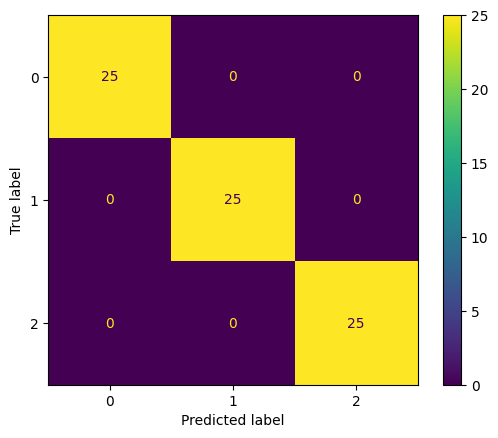

In [7]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
print(metrics.classification_report(Y_test, Y_pred))

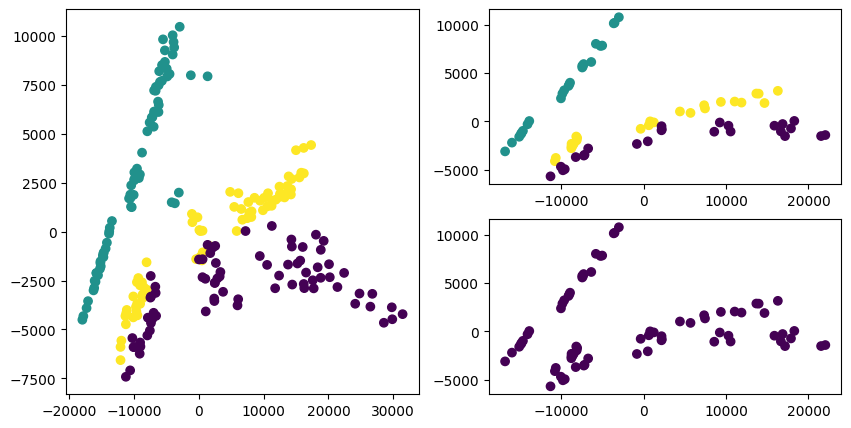

In [8]:
pca = PCA(n_components=2)
pca.fit(X_train)

fig = plt.figure(figsize=(10,5))
g = fig.add_gridspec(1,2)
gs = g[1].subgridspec(2, 1)

ax = fig.add_subplot(g[0,0])
ax.scatter(pca.transform(X_train)[:, 0], pca.transform(X_train)[:, 1], c=Y_train)
ax = fig.add_subplot(gs[0])
ax.scatter(pca.transform(X_test)[:, 0], pca.transform(X_test)[:, 1], c=Y_test)
ax = fig.add_subplot(gs[1])
ax.scatter(pca.transform(X_test)[:, 0], pca.transform(X_test)[:, 1], c=(Y_pred == Y_test))

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(2, 9., num=7),
    'gamma': ['scale'],
}
clf = GridSearchCV(svm.SVC(), param_grid)
clf.fit(X_train, Y_train)
results = clf.cv_results_
results

{'mean_fit_time': array([0.00131388, 0.00114312, 0.00124435, 0.0011682 , 0.00098252,
        0.00096273, 0.00086951]),
 'std_fit_time': array([1.12475101e-04, 1.52896599e-04, 8.96623017e-05, 9.20236912e-05,
        1.15275321e-04, 5.53642645e-05, 6.76256974e-05]),
 'mean_score_time': array([0.00065017, 0.00054784, 0.00053043, 0.00051913, 0.00045695,
        0.00041051, 0.00037985]),
 'std_score_time': array([7.98156182e-05, 8.59587297e-05, 5.04101455e-05, 5.64260975e-05,
        6.14303594e-05, 5.24376503e-05, 3.60935807e-05]),
 'param_C': masked_array(data=[100.0, 1467.7992676220706, 21544.346900318866,
                    316227.7660168379, 4641588.833612782,
                    68129206.90579621, 1000000000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=['scale', 'scale', 'scale', 'scale', 'scale', 'scale',
                    'scale'],
              mask=[False, False, F

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



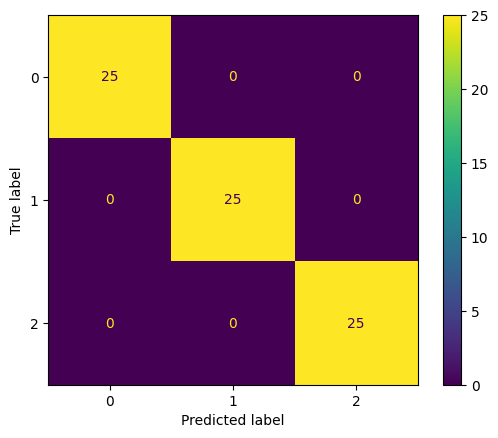

In [10]:
clf = svm.SVC(kernel='rbf', C=1e8, gamma='scale')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
print(metrics.classification_report(Y_test, Y_pred))

# Classification with the integrated signal

              precision    recall  f1-score   support

           0       0.94      0.60      0.73        25
           1       0.83      0.96      0.89        25
           2       0.77      0.92      0.84        25

    accuracy                           0.83        75
   macro avg       0.84      0.83      0.82        75
weighted avg       0.84      0.83      0.82        75



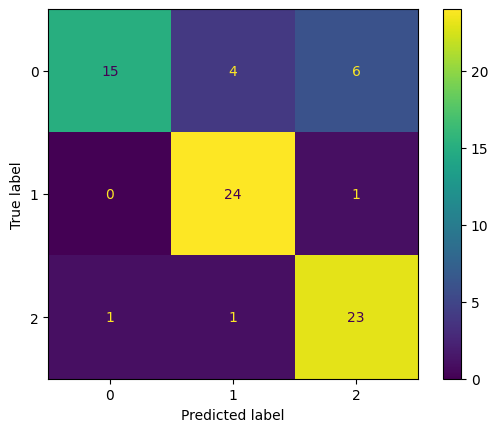

In [11]:
clf = svm.SVC(kernel='linear')
clf.fit(I_train, Y_train)
Y_pred = clf.predict(I_test)
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
print(metrics.classification_report(Y_test, Y_pred))

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(2, 9., num=8),
    'gamma': ['scale'],
}
clf = GridSearchCV(svm.SVC(), param_grid)
clf.fit(I_train, Y_train)
results = clf.cv_results_
results

{'mean_fit_time': array([0.00124063, 0.00148902, 0.00224543, 0.00225477, 0.00241275,
        0.00245128, 0.00209436, 0.00204577]),
 'std_fit_time': array([0.00018379, 0.00032701, 0.0007556 , 0.00086149, 0.00101065,
        0.00082883, 0.00078588, 0.00076168]),
 'mean_score_time': array([0.0004725 , 0.00044217, 0.00038471, 0.00039229, 0.00057683,
        0.0005497 , 0.00035386, 0.00031314]),
 'std_score_time': array([5.46186524e-05, 5.04967173e-05, 6.52076514e-05, 5.67301165e-05,
        1.84481425e-04, 2.34051117e-04, 6.96538808e-05, 1.22692712e-05]),
 'param_C': masked_array(data=[100.0, 1000.0, 10000.0, 100000.0, 1000000.0,
                    10000000.0, 100000000.0, 1000000000.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=['scale', 'scale', 'scale', 'scale', 'scale', 'scale',
                    'scale', 'scale'],
              mask=[False, False, False, False, F

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        25
           1       1.00      1.00      1.00        25
           2       0.88      0.92      0.90        25

    accuracy                           0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75



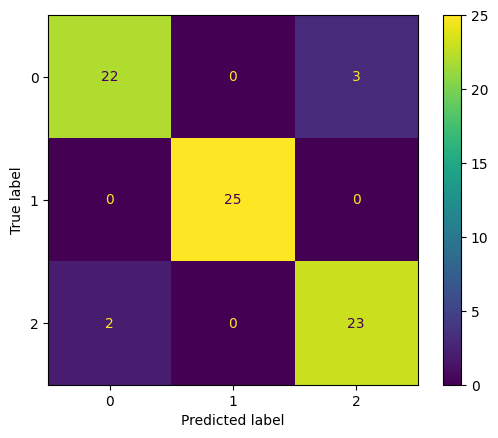

In [13]:
clf = svm.SVC(kernel='rbf', C=1e3, gamma='scale')
clf.fit(I_train, Y_train)
Y_pred = clf.predict(I_test)
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
print(metrics.classification_report(Y_test, Y_pred))

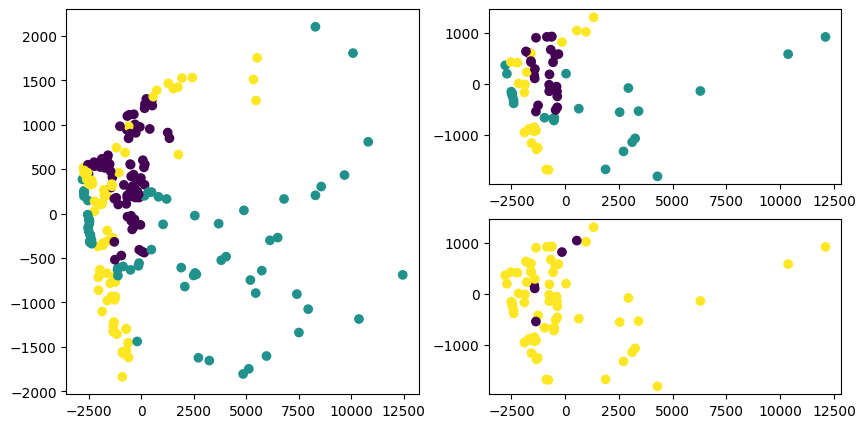

In [14]:
pca = PCA(n_components=2)
pca.fit(I_train)

fig = plt.figure(figsize=(10,5))
g = fig.add_gridspec(1,2)
gs = g[1].subgridspec(2, 1)

ax = fig.add_subplot(g[0,0])
ax.scatter(pca.transform(I_train)[:, 0], pca.transform(I_train)[:, 1], c=Y_train)
ax = fig.add_subplot(gs[0])
ax.scatter(pca.transform(I_test)[:, 0], pca.transform(I_test)[:, 1], c=Y_test)
ax = fig.add_subplot(gs[1])
ax.scatter(pca.transform(I_test)[:, 0], pca.transform(I_test)[:, 1], c=(Y_pred == Y_test))